# Tutorial 18: Multi Assets Algorithmic Trading Backtesting with Vectorbt

## 1. Downloading the data:

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime

import vectorbt as vbt # version=0.26.1
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

import warnings

warnings.filterwarnings("ignore")

# Date range
start = '2010-01-01'
end = '2024-06-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Close', slice(None))]
data.columns = assets

display(data.head())

[*********************100%%**********************]  25 of 25 completed


APA         BA        BAX        BMY  CMCSA    CNP  \
Date                                                                    
2010-01-04  105.870003  56.180000  31.662140  25.629999  8.485  14.52   
2010-01-05  107.120003  58.020000  31.444866  25.230000  8.370  14.41   
2010-01-06  108.800003  59.779999  31.553505  25.219999  8.310  14.27   
2010-01-07  107.150002  62.200001  32.064095  25.240000  8.485  14.41   
2010-01-08  106.589996  61.599998  32.140141  24.820000  8.460  14.24   

                  CPB         DE        HPQ        JCI  ...        NI  \
Date                                                    ...             
2010-01-04  33.869999  56.060001  23.819256  18.879391  ...  6.094303   
2010-01-05  33.930000  55.849998  23.919165  18.785694  ...  6.078585   
2010-01-06  33.549999  55.700001  23.696638  18.723232  ...  6.007859   
2010-01-07  33.040001  56.099998  23.705723  18.858568  ...  5.933202   
2010-01-08  32.830002  57.630001  23.882833  18.921032  ...  5.901768   

                 PCAR        PSA        SEE          T        TGT        TMO  \
Date                                                                           
2010-01-04  24.406668  80.129997  22.020000  21.586103  48.549999  47.500000   
2010-01-05  24.846666  80.790001  21.790001  21.480364  48.730000  47.660000   
2010-01-06  25.173332  80.300003  21.370001  20.853474  49.660000  48.110001   
2010-01-07  25.506666  80.190002  21.590000  20.619335  50.270000  48.110001   
2010-01-08  25.540001  78.730003  21.680000  20.468279  50.070000  48.919998   

                  TXT         VZ   ZION  
Date                                     
2010-01-04  19.040001  31.212946  13.33  
2010-01-05  18.680000  31.269218  13.80  
2010-01-06  19.330000  29.937416  15.00  
2010-01-07  20.190001  29.759218  16.68  
2010-01-08  20.379999  29.777975  16.41  

[5 rows x 25 columns]

## 2 Building the Backtest Function with Backtrader

### 2.1 Building Auxiliary Functions for Rebalancing

In [2]:
vbt.settings.returns['year_freq'] = '252 days'

num_tests = 2000
ann_factor = data.vbt.returns(freq='D').ann_factor

def pre_sim_func_nb(sc, every_nth):
    # Define rebalancing days
    sc.segment_mask[:, :] = False
    sc.segment_mask[every_nth::every_nth, :] = True
    return ()


def pre_segment_func_nb(sc, find_weights_nb, rm, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = sc.close[:sc.i, sc.from_col:sc.to_col]
    else:
        # Look back at a fixed time period
        if sc.i - history_len <= 0:
            return (np.full(sc.group_len, np.nan),)  # insufficient data
        close = sc.close[sc.i - history_len:sc.i, sc.from_col:sc.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(sc, rm, close, num_tests)
    srb_sharpe[sc.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = np.full(sc.group_len, SizeType.TargetPercent)
    direction = np.full(sc.group_len, Direction.LongOnly)
    temp_float_arr = np.empty(sc.group_len, dtype=np.float_)
    for k in range(sc.group_len):
        col = sc.from_col + k
        sc.last_val_price[col] = sc.close[sc.i, col]
    sort_call_seq_nb(sc, weights, size_type, direction, temp_float_arr)
    
    return (weights,)


def order_func_nb(oc, weights):
    col_i = oc.call_seq_now[oc.call_idx]
    return order_nb(
        weights[col_i], 
        oc.close[oc.i, oc.col],
        size_type=SizeType.TargetPercent, 
    )

### 2.2 Building the Optimization Function

In [3]:
import riskfolio as rp

def opt_weights(sc, rm, close, num_tests):
    # Calculate expected returns and sample covariance matrix
    close = pd.DataFrame(close, columns=assets)
    returns = close.pct_change().dropna()

    # Building the portfolio object
    port = rp.Portfolio(returns=returns)
    # Calculating optimum portfolio

    # Select method and estimate input parameters:

    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Estimate optimal portfolio:
    
    port.solvers = ['MOSEK']
    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = rm # Risk measure used, this time will be variance
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    weights = np.ravel(w.to_numpy())
    shp = rp.Sharpe(w, port.mu,
                    cov=port.cov,
                    returns=returns,
                    rm=rm,
                    rf=0,
                    alpha=0.05,
                    solver='MOSEK')

    return shp, weights

### Choosing a Solver

Due to Riskfolio-Lib is based on CVXPY, Riskfolio-Lib can use the same solvers available for CVXPY. The list of solvers compatible with CVXPY is available in [Choosing a solver](https://www.cvxpy.org/tutorial/advanced/index.html) section of CVXPY's documentation. However, to select an adequate solver for each risk measure we can use the following table that specifies which type of programming technique is used to model each risk measure.

| Risk Measure                       | LP | QP | SOCP | SDP | EXP | POW |
|------------------------------------|----|----|------|-----|-----|-----|
| Variance (MV)                      |    |    | X    | X*  |     |     |
| Mean Absolute Deviation (MAD)      | X  |    |      |     |     |     |
| Gini Mean Difference (GMD)         |    |    |      |     | X** |     |
| Semi Variance (MSV)                |    |    | X    |     |     |     |
| Kurtosis (KT)                      |    |    |      |     |     |     |
| Semi Kurtosis (SKT)                |    |    |      |     |     | X   |
| First Lower Partial Moment (FLPM)  | X  |    |      |     |     |     |
| Second Lower Partial Moment (SLPM) |    |    | X    |     |     |     |
| Conditional Value at Risk (CVaR)   | X  |    |      |     |     |     |
| Tail Gini (TG)                     |    |    |      |     | X** |     |
| Entropic Value at Risk (EVaR)      |    |    |      |     | X   |     |
| Relativistic Value at Risk (RLVaR) |    |    |      |     | X** |     |
| Worst Realization (WR)             | X  |    |      |     |     |     |
| CVaR Range (CVRG)                  | X  |    |      |     |     |     |
| Tail Gini Range (TGRG)             |    |    |      |     | X** |     |
| Range (RG)                         | X  |    |      |     |     |     |
| Average Drawdown (ADD)             | X  |    |      |     |     |     |
| Ulcer Index (UCI)                  |    |    |      |     |     | X   |
| Conditional Drawdown at Risk (CDaR)| X  |    |      |     |     |     |
| Entropic Drawdown at Risk (EDaR)   |    |    |      |     | X   |     |
| Relativistic Drawdown at Risk (RLDaR) | |  |      |     | X** |     |
| Maximum Drawdown (MDD)             | X  |    |      |     |     |     |

(*) When SDP graph theory constraints are included. In the case of integer programming graph theory constraints, the model assume the SOCP formulation.

(**) For these models is highly recommended to use MOSEK as solver, due to in some cases CLARABEL cannot find a solution and SCS takes too much time to solve them.

- LP - Linear Programming refers to problems with a linear objective function and linear constraints.
- QP - Quadratic Programming refers to problems with a quadratic objective function and linear constraints.
- SOCP - Second Order Cone Programming refers to problems with second-order cone constraints.
- SDP - Semidefinite Programming refers to problems with positive semidefinite constraints.
- EXP - refers to problems with exponential cone constraints.
- POW - refers to problems with 3-dimensional power cone constraints.


## 3 Building Strategies with Vectorbt

### 3.1 Optimizing Portfolios each Rebalancing Date

In [4]:
%%time

# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'RLVaR': Relativistic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'CDaR': Conditional Drawdown at Risk of uncompounded returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded returns.
# 'RLDaR': Relativistic Drawdown at Risk of uncompounded returns.
# 'MDD': Maximum Drawdown of uncompounded returns (Calmar Ratio).

rms = ["MV", "CVaR", "EVaR", "RLVaR", "WR",
       "CDaR", "EDaR", "RLDaR", "MDD"]

sharpe = {}
portfolio = {}

for i in rms:
    sharpe[i] = np.full(data.shape[0], np.nan)

    # Run simulation with a custom order function (Numba should be disabled)
    portfolio[i] = vbt.Portfolio.from_order_func(
        data,
        order_func_nb,
        pre_sim_func_nb=pre_sim_func_nb,
        pre_sim_args=(30,),
        pre_segment_func_nb=pre_segment_func_nb,
        pre_segment_args=(opt_weights, i, 252*4, ann_factor, num_tests, sharpe[i]),
        cash_sharing=True, 
        group_by=True,
        use_numba=False,
    )

CPU times: user 8min 29s, sys: 6min 24s, total: 14min 54s
Wall time: 4min 7s


### 3.2 Plotting Portfolio Composition each Rebalancing Date

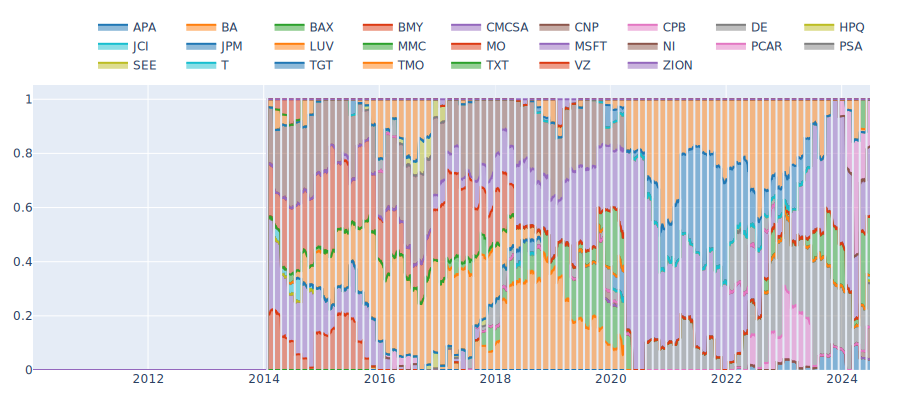

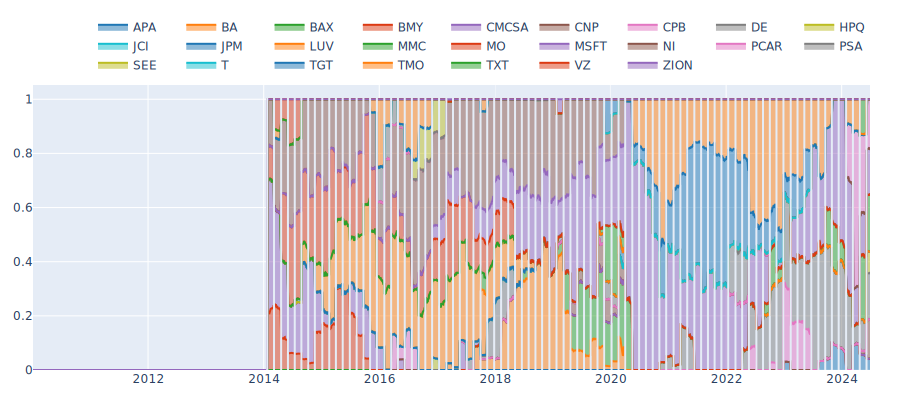

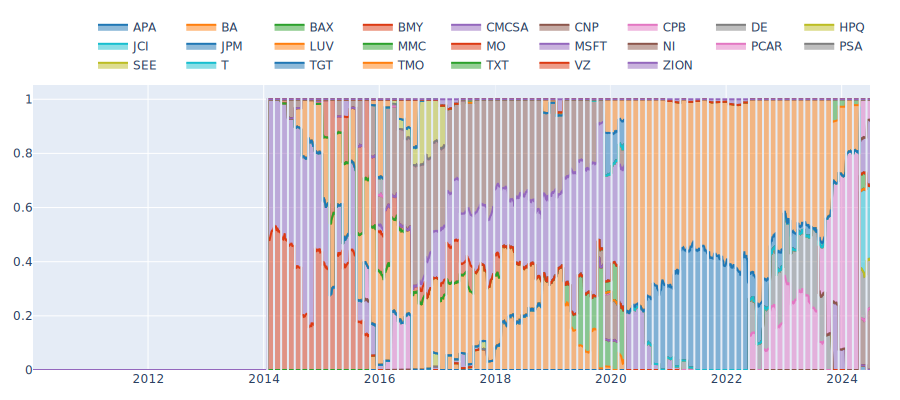

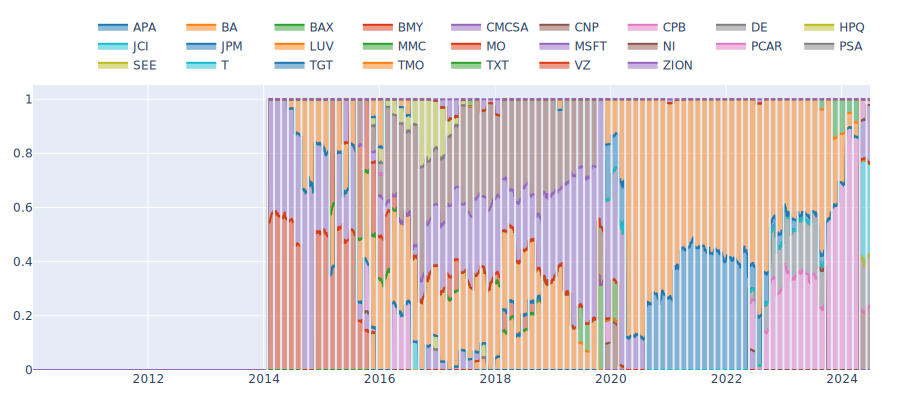

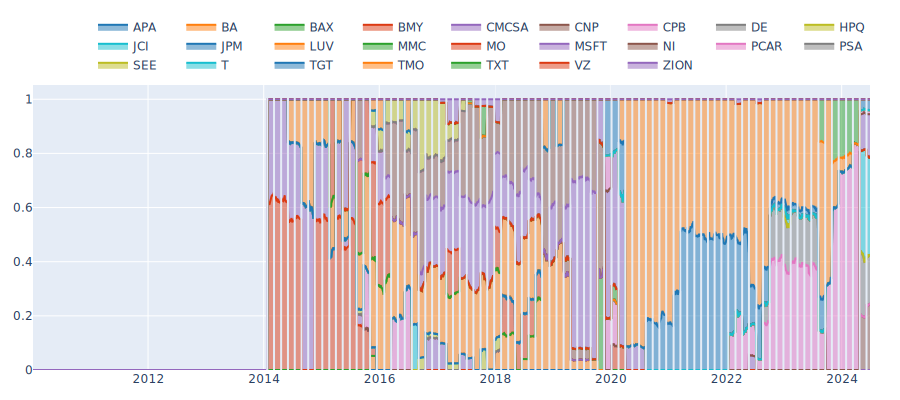

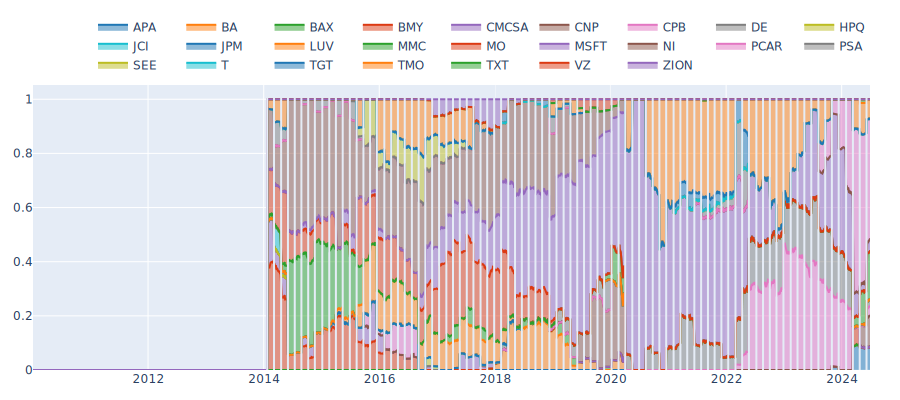

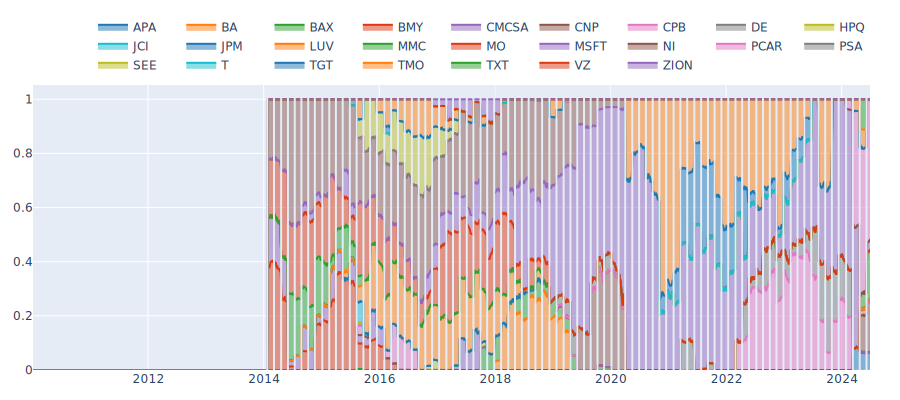

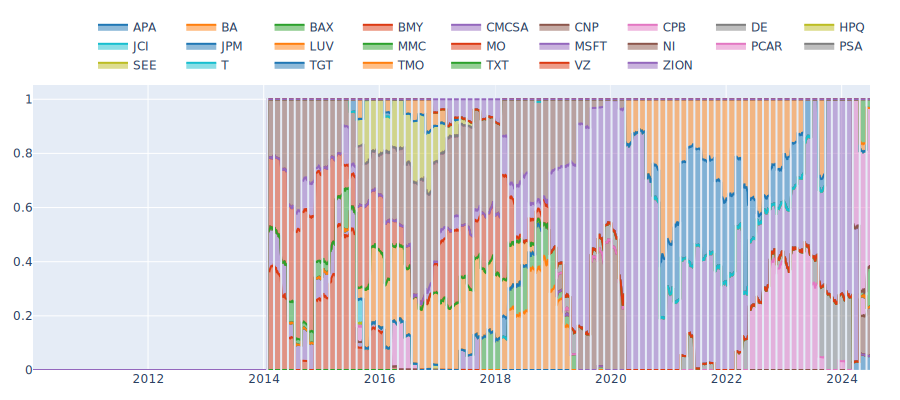

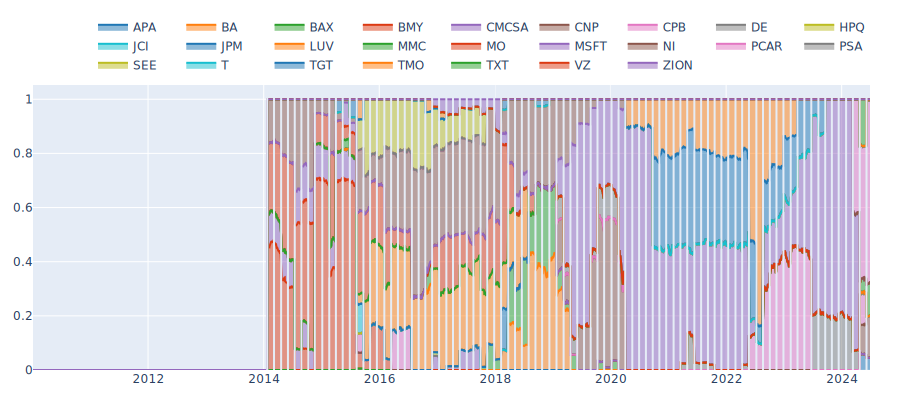

In [5]:
vbt.settings['plotting']['layout']['width'] = 900
vbt.settings['plotting']['layout']['height'] = 400

def plot_allocation(rb_pf):
    # Plot weights development of the portfolio
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=assets,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show_svg()
    
for i in rms:
    plot_allocation(portfolio[i])

### 3.3 Plotting Portfolio Values

<Axes: >

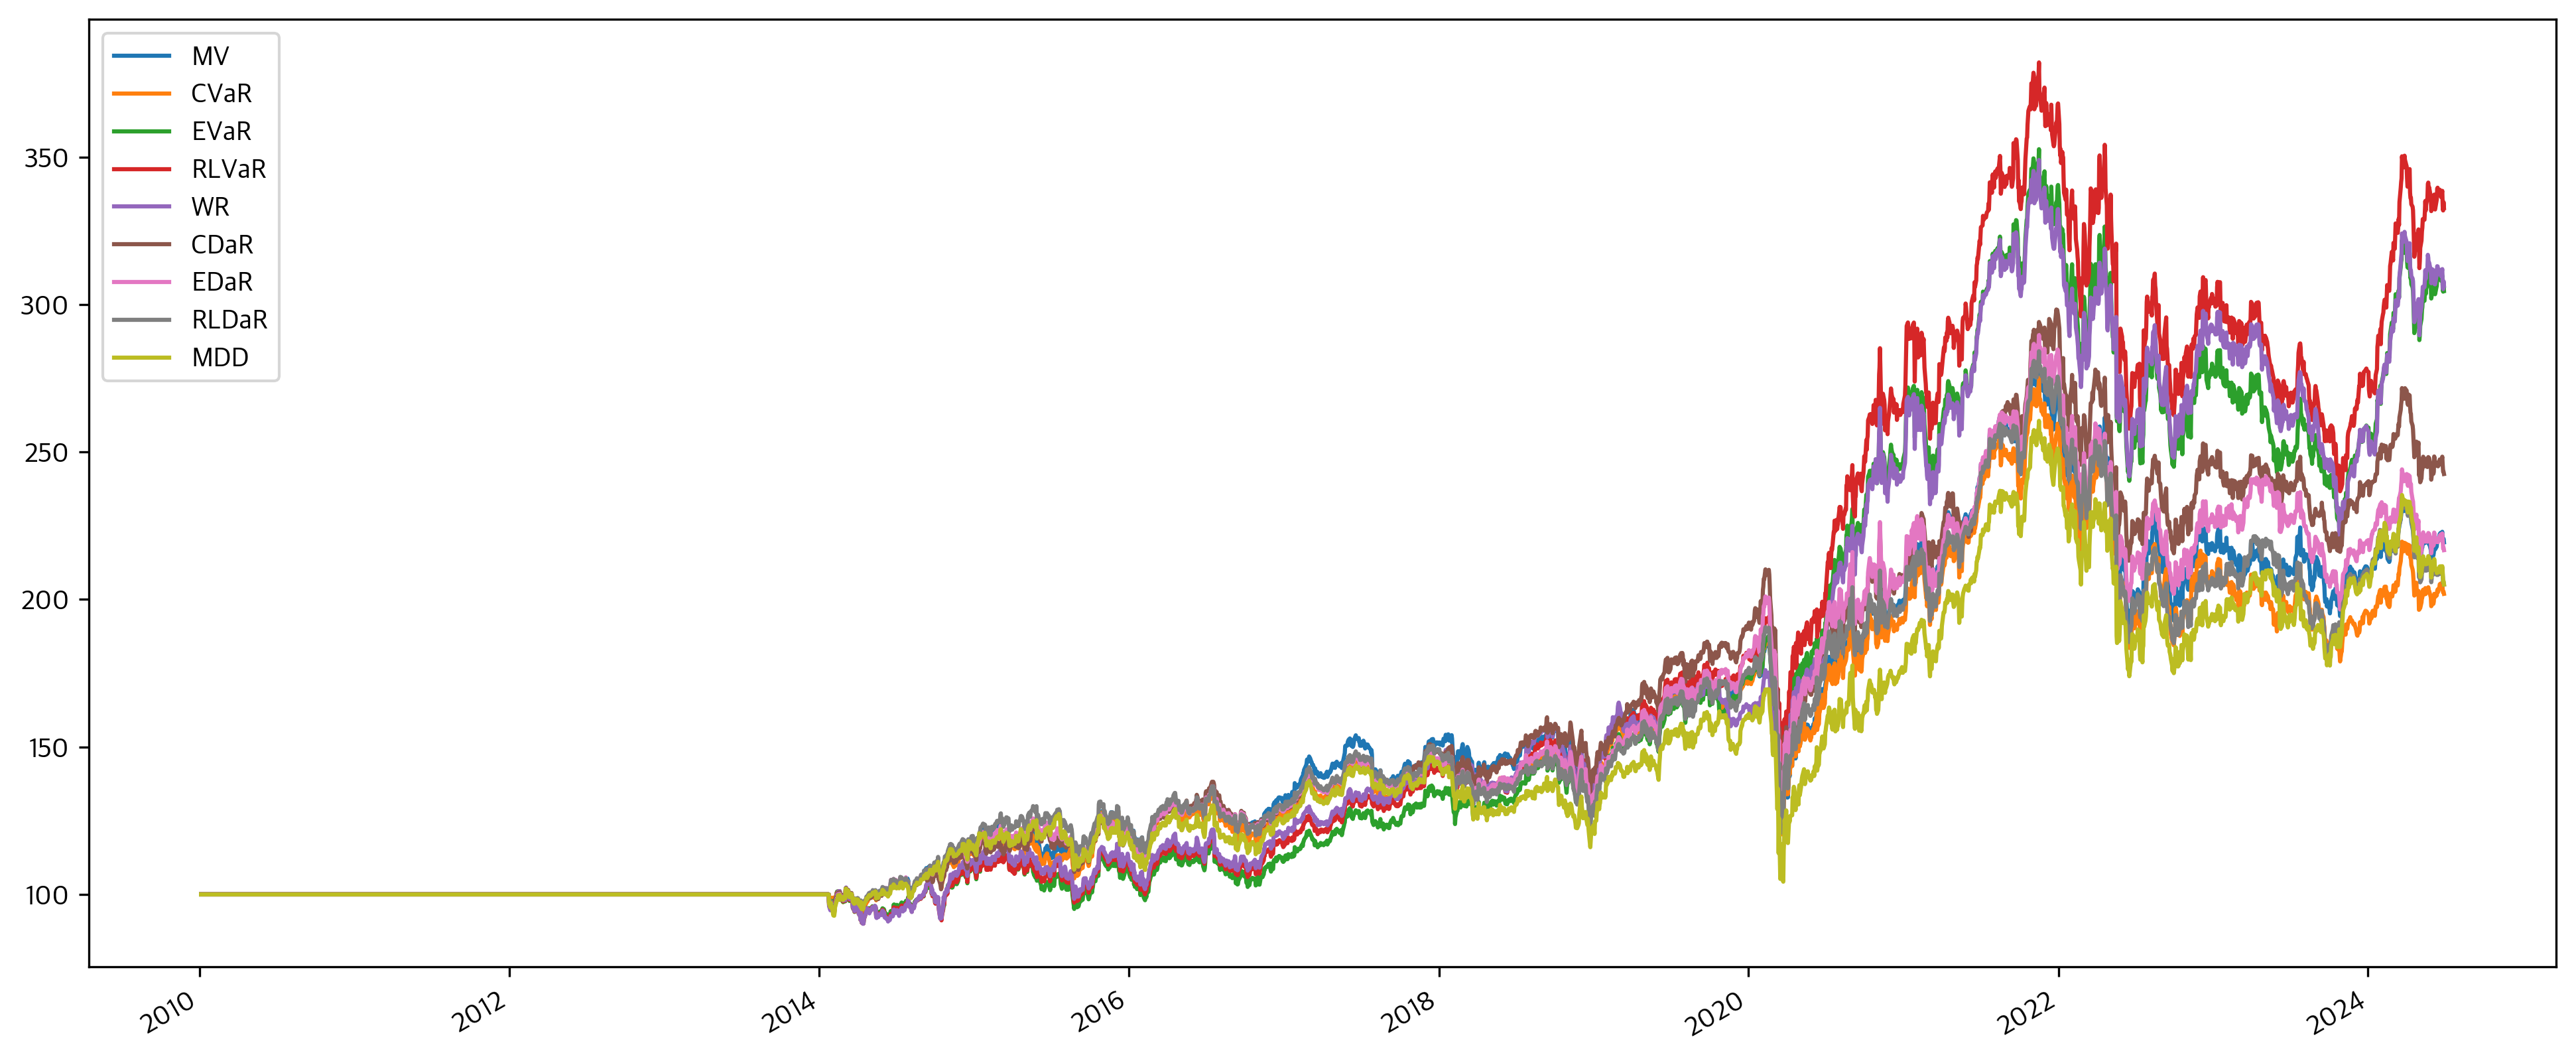

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,7))

values = pd.DataFrame([])
for i in rms:
    a = portfolio[i].value()
    values = pd.concat([values, a], axis=1)

values.columns = rms
values = pd.DataFrame(values)
values.plot(ax=ax)

### 3.4 Portfolio Stats

In [7]:
stats = pd.DataFrame([])
for i in rms:
    a = portfolio[i].stats()
    stats = pd.concat([stats, a], axis=1)

stats.columns = rms
display(stats)

MV                 CVaR  \
Start                       2010-01-04 00:00:00  2010-01-04 00:00:00   
End                         2024-06-28 00:00:00  2024-06-28 00:00:00   
Period                                     3646                 3646   
Start Value                               100.0                100.0   
End Value                            219.380097           201.910798   
Total Return [%]                     119.380097           101.910798   
Benchmark Return [%]                 293.465003           293.465003   
Max Gross Exposure [%]                    100.0                100.0   
Total Fees Paid                             0.0                  0.0   
Max Drawdown [%]                       34.86689            35.498621   
Max Drawdown Duration                     656.0                656.0   
Total Trades                               1086                 1000   
Total Closed Trades                        1061                  978   
Total Open Trades                            25                   22   
Open Trade PnL                        13.451376              7.62846   
Win Rate [%]                          59.754948            54.703476   
Best Trade [%]                        90.644489            62.492925   
Worst Trade [%]                      -82.604281           -62.532563   
Avg Winning Trade [%]                  11.70124             9.635008   
Avg Losing Trade [%]                  -8.763694            -8.809132   
Avg Winning Trade Duration            821.26183           251.551402   
Avg Losing Trade Duration             842.95082           179.582367   
Profit Factor                          2.053061              1.88111   
Expectancy                             0.099839             0.093357   

                                           EVaR                RLVaR  \
Start                       2010-01-04 00:00:00  2010-01-04 00:00:00   
End                         2024-06-28 00:00:00  2024-06-28 00:00:00   
Period                                     3646                 3646   
Start Value                               100.0                100.0   
End Value                            304.612872           332.713242   
Total Return [%]                     204.612872           232.713242   
Benchmark Return [%]                 293.465003           293.465003   
Max Gross Exposure [%]                    100.0                100.0   
Total Fees Paid                             0.0                  0.0   
Max Drawdown [%]                       37.18042            38.055268   
Max Drawdown Duration                     656.0                656.0   
Total Trades                               1117                  984   
Total Closed Trades                        1092                  959   
Total Open Trades                            25                   25   
Open Trade PnL                        10.909451            10.771897   
Win Rate [%]                          58.516484            54.327424   
Best Trade [%]                       162.238098           103.634968   
Worst Trade [%]                      -62.310069           -64.146292   
Avg Winning Trade [%]                 12.632178            11.273162   
Avg Losing Trade [%]                  -8.302807            -8.788441   
Avg Winning Trade Duration          1136.995305           612.840691   
Avg Losing Trade Duration           1286.407982           648.838863   
Profit Factor                          4.091807             4.397566   
Expectancy                              0.17713             0.228847   

                                             WR                 CDaR  \
Start                       2010-01-04 00:00:00  2010-01-04 00:00:00   
End                         2024-06-28 00:00:00  2024-06-28 00:00:00   
Period                                     3646                 3646   
Start Value                               100.0                100.0   
End Value                            306.395723           242.546426   
Total Retur